In [2]:
%matplotlib inline
import matplotlib.gridspec as gridspec
from pycocotools.coco import COCO
from pycocotools import cocoeval

import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.datasets as dset


import pickle as pkl

from fastai.vision import pil2tensor
from fastai.vision import Image as imgg
import cv2 as cv2
from PIL import Image as Image
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)



## Download dataset

In [3]:
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2020-12-05 09:44:48--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.177.91
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.177.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  94.3MB/s    in 2.6s    

2020-12-05 09:44:51 (94.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [4]:
import zipfile
with zipfile.ZipFile('/content/annotations_trainval2017.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Data/annotations')

data_path="/content/Data/annotations/train2017"
json_path="/content/Data/annotations/annotations/instances_train2017.json"

### Exploring the dataset

In [5]:
# Initialize the COCO api 
coco=COCO(json_path)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

# Get Category names in the MS-COCO Dataset
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

loading annotations into memory...
Done (t=16.77s)
creating index...
index created!


In [6]:
# Load categories with the specified ids, in this case all
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n {} \n'.format(' '.join(nms)))

COCO categories: 
 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush 



In [7]:
i = 0
category = []
categoryCount = []
for cat in nms:
    i=i+1
    catIds = coco.getCatIds(catNms=[cat])
    imgIds = coco.getImgIds(catIds=catIds)
    images = coco.loadImgs(imgIds)
    category.append(cat)
    categoryCount.append(len(imgIds))

Creating a subset of Images from desired classes



In [8]:
import random
catIds_1 = coco.getCatIds(catNms=['umbrella'])
imgIds_1 = coco.getImgIds(catIds=catIds_1)
umbrella_images = coco.loadImgs(imgIds_1)

list1=random.sample(umbrella_images,1000)

catIds_2 = coco.getCatIds(catNms=['backpack'])
imgIds_2 = coco.getImgIds(catIds=catIds_2)
backpack_images = coco.loadImgs(imgIds_2)
list2= random.sample(backpack_images,1000)



imgIDSubset = list1 + list2

In [9]:
def getImage(imageinfo, input_image_size):
    train_img = io.imread(imageinfo['coco_url'])
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

In [10]:
def generateImages(images, classes, coco,
                      input_image_size=(224,224),batch_size=200, mode='train'):
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size,input_image_size[0], input_image_size[1], 3)).astype('int')
        
        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, (224,224))
            
                       
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
          c=0
          random.shuffle(images)
            
        yield img 


Save images as .jpg files

In [11]:
def GenerateImages(gen):
    img  = next(gen)
    for i in range(len(img)):      
      io.imsave("/content/Data/Generated_Data_Original/Original_Image/{}.jpg".format(str(i)) , img[i])
    

In [12]:
def visualizeImages(gen):
    img = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

In [13]:

classes = ['backpack', 'umbrella']
val_gen = generateImages(imgIDSubset, classes, coco, batch_size = len(imgIDSubset))
GenerateImages(val_gen)

Streaming output truncated to the last 5000 lines.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/Data/Generated_Data_Original/Original_Image/334.jpg is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/Data/Generated_Data_Original/Original_Image/335.jpg is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/Data/Generated_Data_Original/Original_Image/336.jpg is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/Data/Generated_Data_Original/Original_Image/337.jpg is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/Data/Generated_

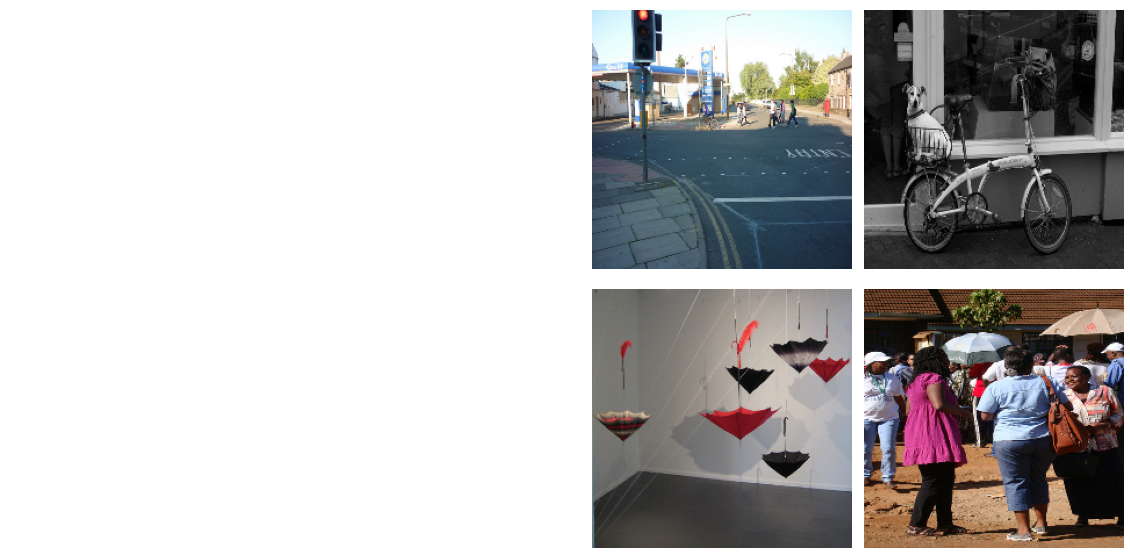

In [ ]:
#Sample images original 
visualizeImages(val_gen)

Deep Convolutional GAN


Train GAN on Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Root directory for dataset
dataroot = "/content/Data/Generated_Data_Original"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

20


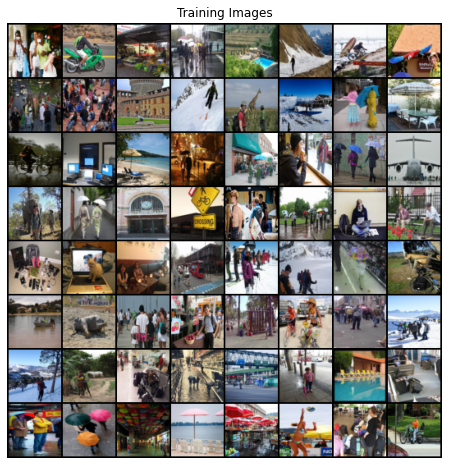

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_original = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader_original))
print(len(dataloader_original))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Weight initialization

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator code

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss functions

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_original, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader_original),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_original)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Results

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training" )
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Results

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader_original))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**Analysis**

After exploring the MS COCO dataset, we can see that the dataset contains 80 classes of common objects and their context. And an image can be formed by combining several classes. This adds complexity to the image as there is diversity in image (combination of classes), image size, number of objects/categories present in the image.

From the GAN training, we observe that, when we are training the dataset of 200 images without the blackened background ( original images), as the iteration increases, the loss for the generator also increases rapidly. on the contrary for Discriminator model its quite the opposite, as the iterations increases, the training loss also reduces. This means that the discriminator is able to classify real samples efficiently from fake ones.

